## 5. PCA

In [ ]:
!pip install pyod
!pip install combo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.1-py3-none-any.whl size=193258 sha256=e2077af9a4543eb951eca09f0a4713aa06be3e5f17e8ab7f604e31c9609cd2dd
  Stored in directory: /root/.cache/pip/wheels/94/75/88/b853cf33b0053b0a001dca55b74d515048b7656e736364eb57
Successfully built pyod
  Preparing metadata (setup.py) ... done
  Created wheel for combo: filename=combo-0.1.3-py3-none-any.whl size=42856 sha256=75084a924dfec037047569984161388491e6fc13b5f6aa5fa9758adc3aa74a91
  Stored in directory: /root/.cache/pip/wheels/7a/48/ff/0d6e1017d8bf3d844d332736fbb268dca767162779f93ff50a
Successfully built combo


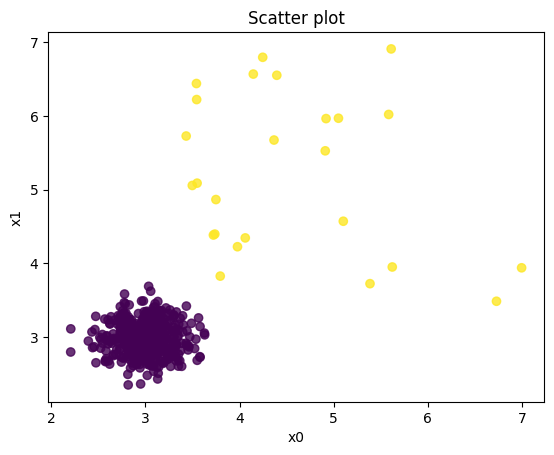

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data
contamination = 0.05 # percentage of outliers
n_train = 500       # number of training points
n_test = 500        # number of testing points
n_features = 6      # number of features
X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train,
    n_test=n_test,
    n_features= n_features,
    contamination=contamination,
    random_state=123)

X_train = 5 - X_train
X_test = 5 - X_test
X_train_pd = pd.DataFrame(X_train)
X_test_pd = pd.DataFrame(X_test)

# Plot
plt.scatter(X_train_pd[0], X_train_pd[1], c=y_train, alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

In [ ]:
##################################
# User-defined utility functions #
##################################

def count_stat(vector):
    # Because it is '0' and '1',
    # we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

def descriptive_stat_threshold(df, pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df.columns = feature_list
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold,
                 'Normal', 'Outlier')
    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    # The count and count %
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100
    # The average
    stat = df.groupby('Group').mean().round(2).reset_index()
    # Put the count and the average together
    stat = cnt.merge(stat, left_on='Group', right_on='Group')
    return (stat)

def confusion_matrix_threshold(
    actual,score, threshold):
    Actual_pred = pd.DataFrame({'Actual': actual, 'Pred': score})
    Actual_pred['Pred'] = np.where(Actual_pred['Pred']<=threshold,0,1)
    cm = pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])
    return (cm)

def confusion_matrix(actual,pred):
    Actual_pred = pd.DataFrame({'Actual': actual,'Pred': pred})
    cm = pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])
    return (cm)

def plot_data():
    plt.scatter(X_train_pd[0], X_train_pd[1],c=y_train, alpha=0.8)
    plt.title('Scatter plot')
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.show()

### Step 1: Build the model

In [ ]:
from pyod.models.pca import PCA
pca = PCA(contamination=0.05)
pca.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = pca.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = pca.decision_scores_  # .decision_scores_ yields the raw outlier scores for the training data
y_train_scores = pca.decision_function(X_train) # You also can use .decision_function()
y_train_pred = pca.predict(X_train) # You also can use .decision_function()

y_test_scores = pca.decision_function(X_test) # You also can use .decision_function()
y_test_pred = pca.predict(X_test) # You also can use .decision_function()

In [ ]:
pca.get_params()

{'contamination': 0.05,
 'copy': True,
 'iterated_power': 'auto',
 'n_components': None,
 'n_selected_components': None,
 'random_state': None,
 'standardization': True,
 'svd_solver': 'auto',
 'tol': 0.0,
 'weighted': True,
 'whiten': False}

In [ ]:
[pca.explained_variance_,
pca.explained_variance_ratio_]

[array([4.13739583, 0.55186189, 0.38712658, 0.34746491, 0.31134247,
        0.27683236]),
 array([0.68818684, 0.09179303, 0.06439205, 0.057795  , 0.05178663,
        0.04604645])]

### Step 2: Determine the threshold

In [ ]:
print("The threshold for the defined contamination rate:" , pca.threshold_)

The threshold for the defined contamination rate: 219.77196222591994


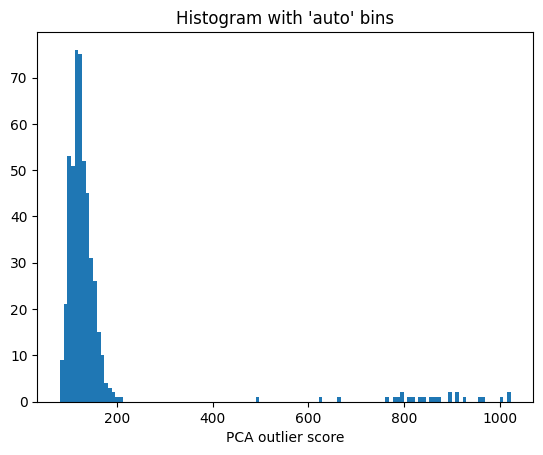

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_train_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.xlabel('PCA outlier score')
plt.show()

In [ ]:
threshold = pca.threshold_
print(threshold)
feature_list = ['Feature_1','Feature_2','Feature_3','Feature_4','Feature_5','Feature_6']
descriptive_stat_threshold(X_train,y_train_scores, threshold)

219.77196222591994


,Group,Count,Count %,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Anomaly_Score
0,Normal,475,95.0,3.00,2.99,2.99,3.01,2.99,3.02,124.59
1,Outlier,25,5.0,4.55,5.21,5.47,5.23,5.03,5.06,844.33


In [ ]:
confusion_matrix_threshold(y_test,y_test_scores,pca.threshold_)

Pred,0,1
Actual,,
0.0,475,0
1.0,0,25


### Comparisons between models

In [ ]:
########
# HBOS #
########
from pyod.models.hbos import HBOS
n_bins = 50
hbos = HBOS(n_bins=n_bins,contamination=0.05)
hbos.fit(X_train)
y_train_hbos_scores = hbos.decision_function(X_train)
y_test_hbos_scores = hbos.decision_function(X_test)

########
# ECOD #
########
from pyod.models.ecod import ECOD
clf_name = 'ECOD'
ecod = ECOD(contamination=0.05)
ecod.fit(X_train)
y_train_ecod_scores = ecod.decision_function(X_train)

########
# PCA  #
########
from pyod.models.pca import PCA
pca = PCA(contamination=0.05)
pca.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pca_scores = pca.decision_function(X_train) # You also can use .decision_function()

# Thresholds
[ecod.threshold_, hbos.threshold_, pca.threshold_]

[16.320821760780653, 5.563712646460526, 219.77196222591994]

In [ ]:
# Put the actual, the HBO score and the ECOD score together
Actual_preds = pd.DataFrame({'Actual': y_train,
                             'HBO_Score': y_train_hbos_scores,
                             'ECOD_Score': y_train_ecod_scores,
                             'PCA_Score': y_train_pca_scores})
Actual_preds['HBOS_pred'] = np.where(Actual_preds['HBO_Score']>hbos.threshold_,1,0)
Actual_preds['ECOD_pred'] = np.where(Actual_preds['ECOD_Score']>ecod.threshold_,1,0)
Actual_preds['PCA_pred'] = np.where(Actual_preds['PCA_Score']>pca.threshold_,1,0)
Actual_preds.head()

,Actual,HBO_Score,ECOD_Score,PCA_Score,HBOS_pred,ECOD_pred,PCA_pred
0,0.0,0.751168,10.779221,164.970934,0,0,0
1,0.0,1.185197,10.225024,132.273351,0,0,0
2,0.0,0.359815,10.706531,119.373451,0,0,0
3,0.0,-1.134714,10.492920,129.482605,0,0,0
4,0.0,2.198864,10.390245,122.114019,0,0,0


In [ ]:
pd.crosstab(Actual_preds['HBOS_pred'],Actual_preds['PCA_pred'])

PCA_pred,0,1
HBOS_pred,,
0,475,0
1,0,25


In [ ]:
pd.crosstab(Actual_preds['ECOD_pred'],Actual_preds['PCA_pred'])

PCA_pred,0,1
ECOD_pred,,
0,475,0
1,0,25
